# Relational primitives 

Relational primitives include transformations of the type we use in SQL

Structured Query Language (pronounced like "sequel")

**Key nouns**:
    - "Relational" database
    - Table
    - Row
    - Column
    - (Primary key)

**Key verbs**:
    - `CREATE TABLE` / `DROP TABLE` to modify the structure of the database
    - `SELECT` to read out some rows
    - `INSERT` / `UPDATE` / `DELETE` to modify (or delete) some rows of tables

**Key modifiers**:
    - `WHERE`: impose condition
    - `ORDER BY`: sort
    - `GROUP BY`: aggregate (e.g., pivot tables in Excel)
    - `JOIN`: combining tables in one query
  

## Pandas data structures and functionality

Pandas is Python's answer to R and SQL.  It's a good tool for small(ish) data analysis -- i.e., when everything fits into memory. The basic new "noun" in pandas is the **data frame**. As a part of pre-exercises, you have received an iPython notebook with some Pandas case study. 
  
It's like a table, with rows and columns (e.g., as in SQL).  Except:
  - The rows can be indexed by something interesting (there is special support for labels like categorical and timeseries data).  This is especially useful when you have timeseries data with potentially missing data points.
  - Cells can store Python objects. (Like in SQL, columns are homogeneous.)
  - Instead of "NULL", the name for a non-existent value is "NA".  Unlike R, Python's data frames only support NAs in columns of some data types (basically: floating point numbers and 'objects') -- but this is mostly a non-issue (because it will "up-cast" integers to float64, etc.)  
  
Pandas provides a "batteries-included" basic data analysis:
  - **Loading data:** `read_csv`, `read_table`, `read_sql`, and `read_html`
  - **Selection, filtering, and aggregation** (i.e., SQL-type operations): There's a special syntax for `SELECT`ing.  There's the `merge` method for `JOIN`ing.  There's also an easy syntax for what in SQL is a mouthful: Creating a new column whose value is computed from other column -- with the bonus that now the computations can use the full power of Python (though it might be faster if it didn't).
  - **Grouping** `groupby`
  - **"Pivot table" style aggregation**: If you're an Excel cognosceti, you may appreciate this.
  - **NA handling**: Like R's data frames, there is good support for transforming NA values with default values / averaging tricks / etc.
  - **Basic statistics:** e.g. `mean`, `median`, `max`, `min`, and the convenient `describe`.
  - **Plugging into more advanced analytics:** Okay, this isn't batteries included.  But still, it plays reasonably with `sklearn`.
  - **Visualization:** For instance `plot` and `hist`.  
 
 
Below, we're going to explore a dataset of mortgage insurance issued by the *Federal Housing Authority (FHA)*. The data is broken down by census tract and tells us how big of a player the FHA is in each tract (how many homes etc ...). 



In [131]:
import pandas as pd

In [132]:
names =["State_Code", "County_Code", "Census_Tract_Number", "NUM_ALL", "NUM_FHA", "PCT_NUM_FHA", "AMT_ALL", "AMT_FHA", "PCT_AMT_FHA"]
df = pd.read_csv('../0_Preexercise/data/fha_by_tract.csv', names=names)  ## Loading a CSV file, without a header (so we have to provide field names)

#create a new column as a function of  a group of columns
df['GEOID'] = df['Census_Tract_Number']*100 + 10**6 * df['County_Code'] \
    + 10**9 * df['State_Code']   
    
#sort by value in column    
df = df.sort_values('State_Code')  
df.head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID
23999,1.0,49.0,9613.0,16,4,25.0000,2184,799,36.58420,1.049961e+09
55215,1.0,3.0,102.0,8,1,12.5000,774,76,9.81912,1.003010e+09
65492,1.0,27.0,NaN,1,0,0.0000,82,0,0.00000,NaN
45193,1.0,95.0,311.0,20,3,15.0000,1495,263,17.59200,1.095031e+09
33750,1.0,39.0,9618.0,14,3,21.4286,1243,333,26.79000,1.039962e+09


In [133]:
#groupby aggregate
df_by_state = df[['State_Code', 'NUM_ALL']].groupby('State_Code').sum()
df_by_state.head(5)

,NUM_ALL
State_Code,
1.0,35833
2.0,7414
4.0,75730
5.0,25531
6.0,307482


In [134]:
#groupby aggregate
df_by_state = df[['State_Code', 'NUM_FHA']].groupby('State_Code').sum()
df_by_state.head(5)

,NUM_FHA
State_Code,
1.0,9269
2.0,1850
4.0,22533
5.0,5665
6.0,88745


# Spark SQL

Spark SQL brings in dataframes and SQL functionality to Spark and in many senses a lot like Pandas' dataframes. 

Spark SQL allows one to query structured data in Spark applications. It supports 2 query parsers: SQL and HiveQL.
We will focus on SQL in the following. Spark SQL and dataframes are often used as synonyms.

It also brings in a DataFrame data structure which is best for analysis of tabular data.

Despite all suggested similarities the implementation of dataframes in Spark and Pandas are rather different.

## Spark DataFrames with Python

This notebook demonstrates examples using Spark DataFrames in Python.

In [136]:
import pyspark
try:
    sc
except NameError:    
    spark = pyspark.sql.SparkSession.builder.master("local[*]").appName("BD course").getOrCreate()
    sc = spark.sparkContext

First, repeat FHA example as we did in Pandas:

In [100]:
delimiter = ","

#csv into spark dataframe   
input_df = spark.read.options(header='true', inferschema='true',delimiter=delimiter).csv('../0_Preexercise/data/fha_by_tract.csv')

#rename columns
oldColumns = input_df.schema.names
newColumns = ["State_Code", "County_Code", "Census_Tract_Number", "NUM_ALL", "NUM_FHA", "PCT_NUM_FHA", "AMT_ALL", "AMT_FHA", "PCT_AMT_FHA"]

from functools import reduce
fha_df = reduce(lambda input_df, idx: input_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), input_df)
fha_df.printSchema()
fha_df.show()

root
 |-- State_Code: integer (nullable = true)
 |-- County_Code: integer (nullable = true)
 |-- Census_Tract_Number: double (nullable = true)
 |-- NUM_ALL: integer (nullable = true)
 |-- NUM_FHA: integer (nullable = true)
 |-- PCT_NUM_FHA: double (nullable = true)
 |-- AMT_ALL: integer (nullable = true)
 |-- AMT_FHA: integer (nullable = true)
 |-- PCT_AMT_FHA: double (nullable = true)

+----------+-----------+-------------------+-------+-------+-----------+-------+-------+-----------+
|State_Code|County_Code|Census_Tract_Number|NUM_ALL|NUM_FHA|PCT_NUM_FHA|AMT_ALL|AMT_FHA|PCT_AMT_FHA|
+----------+-----------+-------------------+-------+-------+-----------+-------+-------+-----------+
|        28|         49|             103.01|      1|      1|      100.0|     71|     71|      100.0|
|        40|          3|               null|      1|      1|      100.0|    215|    215|      100.0|
|        39|        113|              603.0|      3|      3|      100.0|    206|    206|      100.0|
|   

## Creating dataframes

In the previous example we created a dataframe by loading data from CSV file.

In the following, we create dataframe from a list of `Row` objects.

In [101]:
from pyspark.sql import *
# Create Example Data - Departments and Employees

# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee1, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

print (department1)
print (employee2)
print (departmentWithEmployees1.employees[0].email)

Row(id='123456', name='Computer Science')
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
no-reply@berkeley.edu


Create the first DataFrame from a list of the rows.

In [102]:
departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = spark.createDataFrame(departmentsWithEmployeesSeq1)
df1.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[123456,Computer ...|[[michael,armbrus...|
|[789012,Mechanica...|[[matei,null,no-r...|
+--------------------+--------------------+



Create a 2nd DataFrame from a list of rows.

In [103]:
departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = spark.createDataFrame(departmentsWithEmployeesSeq2)
df2.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[345678,Theater a...|[[michael,armbrus...|
|[901234,Indoor Re...|[[xiangrui,meng,n...|
+--------------------+--------------------+



### Working with DataFrames

Union to DataFrames.

In [104]:
unionDF = df1.unionAll(df2)
unionDF.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[123456,Computer ...|[[michael,armbrus...|
|[789012,Mechanica...|[[matei,null,no-r...|
|[345678,Theater a...|[[michael,armbrus...|
|[901234,Indoor Re...|[[xiangrui,meng,n...|
+--------------------+--------------------+



Write the Unioned DataFrame to a Parquet file.

In [105]:
# we will define this utility function once again inline here
def output_cleaner():
    import os
    os.system("rm -rf ./output*")
    print ("Output folders removed!")

In [106]:
#clean tmp directories if necessary
output_cleaner()

Output folders removed!


In [107]:
unionDF.write.parquet("./output_parquet/dfexample_parquet")

Read a DataFrame from the Parquet file.

In [108]:
parquetDF = spark.read.parquet("./output_parquet/dfexample_parquet")
parquetDF.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[345678,Theater a...|[[michael,armbrus...|
|[123456,Computer ...|[[michael,armbrus...|
|[789012,Mechanica...|[[matei,null,no-r...|
|[901234,Indoor Re...|[[xiangrui,meng,n...|
+--------------------+--------------------+



## Working with Struct type columns: explode function

When working with composite columns -- for instance, where each element is an object or struct type, or an array -- we often times need to apply a transformation to a particular class/struct member. Explode function helps to achieve that:
https://spark.apache.org/docs/latest/api/python/_modules/pyspark/sql/functions.html#explode

In [109]:
from pyspark.sql.functions import explode

df = parquetDF.select(explode("employees").alias("e"))
explodedDF = df.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")
explodedDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|     null| wendell|no-reply@berkeley...|160000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
|     null| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



In [110]:
explodedDF

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

## Filtering and sorting dataframes

We can now apply filtering and sorting by an individual data member:

In [112]:
filterDF = explodedDF.filter(explodedDF.firstName == "xiangrui").sort(explodedDF.lastName)
filterDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



Here is how to apply a composite predicate for filtering. Also, by default sorting is in descending order, one can request to do in ascending:

In [113]:
from pyspark.sql.functions import col, asc

# Use `|` instead of `or` 
filterDF = explodedDF.filter((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
filterDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



The `where()` clause is equivalent to `filter()`.

In [114]:
whereDF = explodedDF.where((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
whereDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



## Working with NAs

Replace null values with -- using DataFrame Na functions.

In [115]:
nonNullDF = explodedDF.fillna("--")
nonNullDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|       --| wendell|no-reply@berkeley...|160000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
|       --| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



Retrieve only rows with missing firstName or lastName.

In [116]:
filterNonNullDF = explodedDF.filter(col("firstName").isNull() | col("lastName").isNull()).sort("email")
filterNonNullDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|     null| wendell|no-reply@berkeley...|160000|
|     null| wendell|no-reply@berkeley...|160000|
|    matei|    null|no-reply@waterloo...|140000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



## Grouping and aggregating the data

Example aggregations using `agg()` and `countDistinct()`.

In [117]:
from pyspark.sql.functions import countDistinct

countDistinctDF = explodedDF.select("firstName", "lastName")\
  .groupBy("firstName", "lastName").agg(countDistinct("firstName"))

countDistinctDF.show()

+---------+--------+-------------------------+
|firstName|lastName|count(DISTINCT firstName)|
+---------+--------+-------------------------+
|     null| wendell|                        0|
|    matei|    null|                        1|
| xiangrui|    meng|                        1|
|  michael|armbrust|                        1|
+---------+--------+-------------------------+



Compare the DataFrame and SQL Query Physical Plans (Hint: They should be the same.)

In [118]:
countDistinctDF.explain()

== Physical Plan ==
*HashAggregate(keys=[firstName#1775, lastName#1776], functions=[count(distinct firstName#1775)])
+- *HashAggregate(keys=[firstName#1775, lastName#1776], functions=[partial_count(distinct firstName#1775)])
   +- *HashAggregate(keys=[firstName#1775, lastName#1776, firstName#1775], functions=[])
      +- Exchange hashpartitioning(firstName#1775, lastName#1776, firstName#1775, 200)
         +- *HashAggregate(keys=[firstName#1775, lastName#1776, firstName#1775], functions=[])
            +- *Project [e#1772.firstName AS firstName#1775, e#1772.lastName AS lastName#1776]
               +- Generate explode(employees#1755), false, false, [e#1772]
                  +- *FileScan parquet [employees#1755] Batched: false, Format: Parquet, Location: InMemoryFileIndex[file:/home/jovyan/work/3_DataFramesSQL/output_parquet/dfexample_parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<employees:array<struct<firstName:string,lastName:string,email:string,salary:bigint>

If you are coming from SQL rather than Pandas, you might prefer the following:

In [119]:
# register the DataFrame as a temp table so that we can query it using SQL
explodedDF.registerTempTable("df_example")

# Perform the same query as the DataFrame above and return ``explain``
countDistinctDF_sql = spark.sql("SELECT firstName, lastName, count(distinct firstName) as distinct_first_names FROM df_example GROUP BY firstName, lastName")

countDistinctDF_sql.explain()

== Physical Plan ==
*HashAggregate(keys=[firstName#1775, lastName#1776], functions=[count(distinct firstName#1775)])
+- *HashAggregate(keys=[firstName#1775, lastName#1776], functions=[partial_count(distinct firstName#1775)])
   +- *HashAggregate(keys=[firstName#1775, lastName#1776, firstName#1775], functions=[])
      +- Exchange hashpartitioning(firstName#1775, lastName#1776, firstName#1775, 200)
         +- *HashAggregate(keys=[firstName#1775, lastName#1776, firstName#1775], functions=[])
            +- *Project [e#1772.firstName AS firstName#1775, e#1772.lastName AS lastName#1776]
               +- Generate explode(employees#1755), false, false, [e#1772]
                  +- *FileScan parquet [employees#1755] Batched: false, Format: Parquet, Location: InMemoryFileIndex[file:/home/jovyan/work/3_DataFramesSQL/output_parquet/dfexample_parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<employees:array<struct<firstName:string,lastName:string,email:string,salary:bigint>

Sum up all the salaries

In [120]:
salarySumDF = explodedDF.agg({"salary" : "sum"}) 
salarySumDF.show()

+-----------+
|sum(salary)|
+-----------+
|    1040000|
+-----------+



In [121]:
type(explodedDF.salary)

pyspark.sql.column.Column

Print the summary statistics for the salaries.

In [122]:
explodedDF.describe("salary").show()

+-------+------------------+
|summary|            salary|
+-------+------------------+
|  count|                 8|
|   mean|          130000.0|
| stddev|23904.572186687874|
|    min|            100000|
|    max|            160000|
+-------+------------------+



## An example using Pandas & Matplotlib Integration

There is a connector allowing to convert Spark dataframes into pandas dataframes. Once you have the data in Pandas dataframes, several plotting front-ends are available. Including Matplotlib:

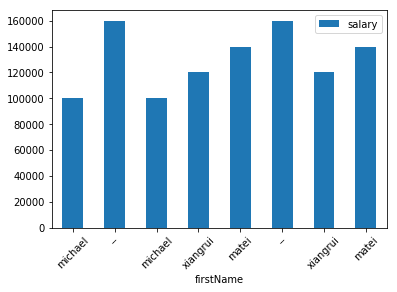

In [123]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)
#display()

## User Defined Functions in Python

This notebook contains some examples of creating a *UDF* in Python and registering it for use in Spark SQL.


### Step 1: Register a function as a UDF.

After the standard function is defined in Python, you need to register it as a UDF to be able to use on Spark DataFrames

In [124]:
def squared(s):
    return s * s

spark.udf.register("squaredWithPython", squared)

Optionally, you can also explicitly set the return type of your UDF.

In [125]:
from pyspark.sql.types import LongType

spark.udf.register("squaredWithPython", squared, LongType())

### Step 2: Call the UDF in Spark SQL

Create a dataframe to test the newly created UDF on:

In [126]:
spark.range(1, 20).registerTempTable("test_dataframe")

### Step 3: Use UDF with DataFrames

In [127]:
from pyspark.sql.functions import udf

squared_udf = udf(squared, LongType())
df = spark.table("test_dataframe")
df.select("id", squared_udf("id").alias("id_squared")).show()

+---+----------+
| id|id_squared|
+---+----------+
|  1|         1|
|  2|         4|
|  3|         9|
|  4|        16|
|  5|        25|
|  6|        36|
|  7|        49|
|  8|        64|
|  9|        81|
| 10|       100|
| 11|       121|
| 12|       144|
| 13|       169|
| 14|       196|
| 15|       225|
| 16|       256|
| 17|       289|
| 18|       324|
| 19|       361|
+---+----------+



Back to our example with homes and Federal Housing Authority: 

In [128]:
from pyspark.sql.functions import udf
from math import pow

def geoid(x,y,z):
    if x is not None and y is not None and z is not None:
        return 100*x + pow(10,6)*y + pow(10,9)*z
    else:
        return None

geoid_udf = udf(geoid)

#geoid = lambda x,y,z: x*100 + 10**6*y + 10**9*z
fha_df = fha_df.withColumn("GEOID",geoid_udf("Census_Tract_Number","County_Code","State_Code"))

fha_df.sort('State_Code').show()  

+----------+-----------+-------------------+-------+-------+-----------+-------+-------+-----------+-------------+
|State_Code|County_Code|Census_Tract_Number|NUM_ALL|NUM_FHA|PCT_NUM_FHA|AMT_ALL|AMT_FHA|PCT_AMT_FHA|        GEOID|
+----------+-----------+-------------------+-------+-------+-----------+-------+-------+-----------+-------------+
|      null|       null|               null|   9477|   1932|    20.3862|1575871| 331515|    21.0369|         null|
|         1|         87|             2319.0|      1|      1|      100.0|     28|     28|      100.0|  1.0872319E9|
|         1|         25|            9580.01|      3|      3|      100.0|    459|    459|      100.0|1.025958001E9|
|         1|         97|               50.0|      2|      2|      100.0|    128|    128|      100.0|   1.097005E9|
|         1|        101|              56.03|      2|      2|      100.0|    126|    126|      100.0|1.101005603E9|
|         1|         91|             9732.0|      2|      2|      100.0|    168|

In [129]:
#groupby aggregate
fha_df_by_state = fha_df.select('State_Code', 'NUM_ALL').groupBy('State_Code').sum()
fha_df_by_state.show(5)

+----------+---------------+------------+
|State_Code|sum(State_Code)|sum(NUM_ALL)|
+----------+---------------+------------+
|        31|          16554|       18367|
|        53|          76797|       68937|
|        34|          66708|       58948|
|        28|          17892|       16140|
|        26|          64480|       73917|
+----------+---------------+------------+
only showing top 5 rows



In [130]:
#groupby aggregate
fha_df_by_state = fha_df.select('State_Code', 'NUM_FHA').groupBy('State_Code').sum()
fha_df_by_state.show(5)

+----------+---------------+------------+
|State_Code|sum(State_Code)|sum(NUM_FHA)|
+----------+---------------+------------+
|        31|          16554|        4808|
|        53|          76797|       15026|
|        34|          66708|       14056|
|        28|          17892|        3825|
|        26|          64480|       23131|
+----------+---------------+------------+
only showing top 5 rows

